In [401]:
import sys, getopt, os.path
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import math,h5py, pandas
from scipy import integrate
from scipy.fftpack import fft, hilbert
from scipy.signal import butter, lfilter
from geopy.distance import great_circle
import matplotlib.ticker as ticker
import yaml

In [402]:
def getSNR(cfsf,r,f,SNRmin):
    NoiseWinLength = 300 # in seconds
    SigWinC = np.array([2,4]) #signal window for velocity, in km/s
    SigWinT = np.zeros((len(r),2))
    SNR = np.zeros(np.shape(r))
    for i in range(len(r)):
        SigWinT[i,:] = r[i]/SigWinC

    dt = 1/np.max(f)
    t = (np.linspace(-len(f)/2,len(f)/2-1,len(f))-0.5)*dt
    cfst = np.zeros(np.shape(cfsf))
    for i in range(len(cfsf)):
        cfst[i,:] = np.real(np.fft.fftshift(np.fft.ifft(cfsf[i,:])))
        cfst[i,:] = cfst[i,:] /np.max(cfst[i,:])

    id0 = int(len(t)/2)
    cfst12 = cfst[:,id0::]
    cfst21 = cfst[:,id0::-1]
    for j in range(len(r)):
        c12h= hilbert(cfst12[j,:])
        c21h= hilbert(cfst21[j,:])
        groupCF12 = np.sqrt(cfst12[j,:]**2 + c12h**2)
        groupCF21 = np.sqrt(cfst21[j,:]**2 + c21h**2)
        nnSigWinL = int(np.ceil(SigWinT[j,1]/dt))
        nnSigWinR = int(np.floor(SigWinT[j,0]/dt))
        if nnSigWinL >= nnSigWinR:
            continue
        nnNoiseWinL = nnSigWinR
        nnNoiseWinR = nnSigWinR+int(round(NoiseWinLength/dt))

        #print("nnSigWinL: ",nnSigWinL)
        #print("nnSigWinR: ",nnSigWinR)
        SigAmp12 = np.max(groupCF12[nnSigWinL:nnSigWinR])
        SigAmpAve12 = np.mean(groupCF12[nnSigWinL:nnSigWinR])
        NoiseAmpAve12 = np.mean(groupCF12[nnNoiseWinL:nnNoiseWinR])
        if NoiseAmpAve12 == 0:
            if SigAmp12 > 0:
                SNR12 = 100
            else:
                SNR12 = 0
        else:
            SNR12 = SigAmp12/NoiseAmpAve12

        SigAmp21 = np.max(groupCF21[nnSigWinL:nnSigWinR])
        SigAmpAve21 = np.mean(groupCF21[nnSigWinL:nnSigWinR])
        NoiseAmpAve21 = np.mean(groupCF21[nnNoiseWinL:nnNoiseWinR])
        if NoiseAmpAve21 == 0:
            if SigAmp21 > 0:
                SNR21 = 100
            else:
                SNR21 = 0
        else:
            SNR21 = SigAmp21/NoiseAmpAve21

        SNR[j] = np.nan_to_num(min(SNR12,SNR21))
        
    idx = []
    for k in range(len(r)):
        if SNR[k] < np.mean(SNR)*SNRmin:
            idx.append(k)

    return idx

def ricker(t,fc,t0):
 if (t<=0.0):
    v=0.0
 f0 = np.sqrt(math.pi)/2.0
 u = (t-t0)*2.0*math.pi*fc
 v=(u**2.0/4.0-0.5)*np.exp(-u**2.0/4.0)*f0
 return v

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def print_help_info():
  print('\nUsage: fig4seismo2d.py [-h] | [-i inputpath]' +
    ' [-o outputpath] [-c fileFDconf] [-s isrc] [-d stride]')
  print('  [inputpath  ]: directory of the coordinate data files.')
  print('  [outputpath ]: directory of the seismogram data files.')
  print('  [fileFDconf   ]: name of the configure file for FD.')
  print('  [isrc   ]: code number of the virtrual source')
  print('  [stride   ]: number of stations to skip for plotting.')

In [403]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

dir_image = dir_project + info_basic['rdir_image']+'model_validate/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_CC = os.getcwd()+'/'+dir_CC_workspace[1:] + info_basic['rdir_CC']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)

dir_file = os.getcwd()+'/ModelValidCode/ModelValidCode/parameter_prepare/'

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.2_01-01/


In [404]:
stride = 1
isline = False
LenFD = 3
isrc = 20
dir_src = dir_project + 'ModelValidate/src'+str(isrc)+'/'
putinrou = [dir_CC + 'CFs_modelvalidate/'+ 'gather_all_modelvalidate.h5']
syn_stalist = dir_file + 'stations_in.txt'
sele_stalist = dir_file + 'stations_in.txt'
srclist = dir_file + 'stations_virsrc.txt'
inputpath = dir_src + 'input/'
outputpath = dir_src + 'output/'
fileFDconf = dir_src + 'SeisFD3D.conf'


In [405]:
virsta = []
sta_profile = pandas.read_table(srclist, header=None, sep='\\s+')
net = list(sta_profile[0][:])
sta = list(sta_profile[1][:])
for i in range(len(sta)):
    #virsta.append(str(str(net[i]) + '-' + str(sta[i])))
    virsta.append(str(sta[i]))
srcsta = virsta[isrc-1]
print('  srcsta:\t', srcsta)

  srcsta:	 R1709


In [406]:
#=============================read observed Ccfs====================================
CC_file = []
CC_prof = []
for i in range(len(putinrou)):
  CC_prof.append(pandas.read_hdf(putinrou[i], 'cc_prof'))
  with h5py.File(putinrou[i], mode = "r") as file_rou:
      CC_file.append(np.array(file_rou[list(file_rou.keys())[0]]))
CC_array = CC_file[0]
CC_table = CC_prof[0]
f_prof = pandas.read_hdf(putinrou[0], 'freq')
freq = np.array(f_prof[:])[:,0]

In [407]:
#==============selec Ccfs based on srcstat=====================================
sele_netsta = []
with open(sele_stalist, 'r') as f:
    while True:
        tmp = f.readline()
        if tmp:
            sele_netsta.append(tmp.split()[0] + '-' + tmp.split()[1])
        else:
            break

part_CC = []
part_dis = []
CC_sta_name = []
cc_name = CC_table['0cc_name']
indexes = []
for i in range(len(cc_name)):
    cc_pairs_sta2 = cc_name[i].split('_')
    netsta1 = cc_pairs_sta2[0]
    netsta2 = cc_pairs_sta2[1]
    #print(cc_pairs_sta2)
    if srcsta in cc_pairs_sta2:
    #if (netsta1 in sele_netsta) and (netsta2 in sele_netsta) and (srcsta in cc_pairs_sta2):
       indexes.append(i)
       part_CC.append((CC_array[i,:]).copy())
       part_dis.append(CC_table.iloc[i,3]) #km
       if srcsta == netsta1:
          CC_sta_name.append(netsta2)
       else:
          CC_sta_name.append(netsta1)

#print("CC_sta_name: ", CC_sta_name)
part_CC = np.array(part_CC)
part_dis = np.array(part_dis)
dele_cc_rows = []
for CC_num in range(part_CC.shape[0]):
  if part_CC[CC_num,:].all() == 0:
      dele_cc_rows.append(CC_num)
  if part_dis[CC_num] == 0 or part_dis[CC_num]>= 800:
      dele_cc_rows.append(CC_num)
dele_cc_rows = list(set(dele_cc_rows))
dele_cc_rows.sort()
raw_rou_nonezerocc = np.delete(part_CC, dele_cc_rows, axis = 0)
dis_vin_nonezerocc = np.delete(part_dis, dele_cc_rows, axis = 0)
for counter, index in enumerate(dele_cc_rows):
    index = index-counter
    CC_sta_name.pop(index)

print("raw_rou_nonezerocc: ", raw_rou_nonezerocc.shape)
print("dis_vin_nonezerocc: ", dis_vin_nonezerocc.shape)
#print("time: ", time)

raw_rou_nonezerocc:  (1107, 400)
dis_vin_nonezerocc:  (1107,)


In [408]:
"""
idel = getSNR(raw_rou_nonezerocc,dis_vin_nonezerocc,freq,SNRmin=0)
idel = list(set(idel))
idel.sort()
raw_rou_nonezerocc = np.delete(raw_rou_nonezerocc,idel,axis=0)
dis_vin_nonezerocc = np.delete(dis_vin_nonezerocc,idel,axis=0)
for counter, index in enumerate(idel):
    index = index-counter
    CC_sta_name.pop(index)
"""
#============obtain time-domain Green's function=================================================
ncfs0 = raw_rou_nonezerocc
robs = dis_vin_nonezerocc #km
dtobs = 1/np.max(freq)
tobs = (np.linspace(-len(freq)/2, len(freq)/2-1, len(freq))-0.5)*dtobs
ncfst = np.zeros(np.shape(ncfs0))
for i in range(len(ncfs0)):
  ncfst[i,:] = np.real(np.fft.fftshift(np.fft.ifft(ncfs0[i,:])))

cfs = (ncfst[:,int(len(freq)/2):1:-1] + ncfst[:,int(len(freq)/2+1)::]) / 2 
cfs_grad = -np.gradient(cfs,axis=1,edge_order=1)/dtobs

In [409]:
#===========convolve with the ricker wavelet=============================================================
tt = tobs[int(len(freq)/2+1)::]
wavelet = np.zeros(len(tt))
waveobs = np.zeros((cfs_grad.shape[0],len(tt)))
for i in range(len(tt)):
   wavelet[i] = ricker(tt[i],10,0.15)
indx_obs = int(0.15/dtobs)
for j in range(cfs_grad.shape[0]):
   tmp = np.convolve(wavelet,cfs_grad[j,:])
   waveobs[j,:] = tmp[indx_obs:len(tt)+indx_obs]

In [410]:
#===========windowed waveform=================================================
fs_obs = 1.0/(tt[1]-tt[0])
#bands = np.array([[3,7],[5,10],[8,15],[12,20]])
#aver = np.array([3.12,3.12,3.12,3.30])
#bands = np.array([[0.1,0.2],[1/7,1/12],[0.1,1/15],[1/12,1/20]])
bands = np.array([[1/18,1/12],[1/15,1/10],[1/12,1/7],[1/10,1/5]])
lowcut = 1.0 / bands[:,1]
highcut = 1.0 / bands[:,0]
wave0obs = np.zeros(waveobs.shape) #3-7s
wave1obs = np.zeros(waveobs.shape) #5-10s
wave2obs = np.zeros(waveobs.shape) #8-15s
wave3obs = np.zeros(waveobs.shape) #12-20s

for i in range(waveobs.shape[0]):
    wave0obs[i,:] = butter_bandpass_filter(waveobs[i,:], lowcut[0], highcut[0], fs_obs, order=2)
    wave1obs[i,:] = butter_bandpass_filter(waveobs[i,:], lowcut[1], highcut[1], fs_obs, order=2)
    wave2obs[i,:] = butter_bandpass_filter(waveobs[i,:], lowcut[2], highcut[2], fs_obs, order=2)
    wave3obs[i,:] = butter_bandpass_filter(waveobs[i,:], lowcut[3], highcut[3], fs_obs, order=2)


In [411]:
#===================Process synthetic waveforms==========================================================
confFD = open(fileFDconf, 'r')
linesFD = confFD.read().split('\n')
for j in range(len(linesFD)):
  line = linesFD[j]
  if line.find('#') >= 0: line = line[:line.find('#') - 1]
  if line.split(' ')[0] == 'dims':
    dims = [int(v) for v in line.split() if v.isdigit()][0:3]

confFD.close()

staloc = np.loadtxt(syn_stalist, usecols=[2,3])
syn_netsta = []
with open(syn_stalist, 'r') as f:
    while True:
        tmp = f.readline()
        if tmp:
           #syn_netsta.append(tmp.split()[0] + '-' + tmp.split()[1])
           syn_netsta.append(tmp.split()[0])
        else:
            break
Srloc = staloc[syn_netsta.index(srcsta)]
#==============================================================================
whitems = ['Vx', 'Vy', 'Vz', 'Txx', 'Tyy', 'Tzz', 'Txy', 'Txz', 'Tyz']

isfirstget = True
isgottime = False
iline = 0
for k in range(dims[2]):
  for j in range(dims[1]):
    for i in range(dims[0]):
      filename = '{}seismo_mpi{:02d}{:02d}{:02d}.nc'.format(outputpath, i, j, k)
      if not os.path.isfile(filename):
        continue
      ssm = nc.Dataset(filename, 'r')
      filename = '{}station_mpi{:02d}{:02d}{:02d}.nc'.format(inputpath, i, j, k)
      stn = nc.Dataset(filename, 'r')
      pid = stn.variables['id'][:]#get the station index(two dimension)
      if not isgottime:
        t = ssm.variables['time'][:]
        isgottime = True
        nt = t.size # the acctural points stored in the Seis.nc
      for ip in range(pid.shape[0]):
        if pid[ip, 1] == iline:#equals to the L/P-index(P=0) ////get id from STA.nc ///to confirm line number
          ttvar = np.zeros((1, 1, nt))
          ttvar[0, 0, :] = np.reshape(ssm.variables[whitems[0]][:, ip], [nt]) #get the ip strip in Vx, and flaten into [nt] case
          for iw in range(1,9):
            tvar = np.reshape(ssm.variables[whitems[iw]][:, ip], [1, 1, nt])
            ttvar = np.append(ttvar, tvar, axis = 1) #all stored in falten case and different in layerd direction
          if isfirstget:
            dvar = ttvar[:] #data  dvar[Var][Var][nt]
            ipoint = pid[ip, 0] # relevent index(start from 1)
            isfirstget = False
          else:
            dvar = np.append(dvar, ttvar, axis = 0)
            ipoint = np.append(ipoint, pid[ip, 0])
      stn.close()
      ssm.close()
#ipoint is absolute point location in point series(sequence in line).
if 'ipoint' not in globals():
  raise IOError('Maybe no seismogram data files in the outputpath: ' + outputpath)

# nt point in time series
# npt point in record index series

npt = ipoint.size
pvar = np.zeros((npt, 9, nt)) #RECiver Var Time
for ip in range(npt):
  pvar[ipoint[ip] - 1, :, :] = dvar[ip, :, :] 
for iw in range(9):
  if iw < 3:
    pvar[:, iw, :] = pvar[:, iw, :]/1.0e3
  else:
    pvar[:, iw, :] = pvar[:, iw, :]/1.0e9

print(np.shape(pvar))

# Integrate to obtain Displacement
Vz = pvar[:, 2, :]
Dz0 = integrate.cumtrapz(Vz, t, axis=1, initial=0)
stpindx = int(0.15/(t[1]-t[0]))
tc = t[:len(t)-stpindx]
Dz = Dz0[:,stpindx:]


# filter-----------------------------------------------------------
fs_syn = 1.0/(t[1]-t[0])
wave0syn = np.zeros(Dz.shape) #3-7s
wave1syn = np.zeros(Dz.shape) #5-10s
wave2syn = np.zeros(Dz.shape) #8-15s
wave3syn = np.zeros(Dz.shape) #12-20s

for i in range(Dz.shape[0]):
    wave0syn[i,:] = butter_bandpass_filter(Dz[i,:], lowcut[0], highcut[0], fs_syn, order=2)
    wave1syn[i,:] = butter_bandpass_filter(Dz[i,:], lowcut[1], highcut[1], fs_syn, order=2)
    wave2syn[i,:] = butter_bandpass_filter(Dz[i,:], lowcut[2], highcut[2], fs_syn, order=2)
    wave3syn[i,:] = butter_bandpass_filter(Dz[i,:], lowcut[3], highcut[3], fs_syn, order=2)
#==============correct synthesized waveform with observed waveform based on station interval==========================================================
#print("robs: ", robs)
#print("rsyn: ", rsyn)
indxcorr_syn = []
indxcorr_obs = []
r_plot = []
#print("netsta: ", netsta)
for i in range(len(robs)):
  #print("CC_sta_name: ", CC_sta_name[i])
  if CC_sta_name[i] in syn_netsta:
      indxcorr_obs.append(i)
      indxcorr_syn.append(syn_netsta.index(CC_sta_name[i]))
      r_plot.append(robs[i])
#print("indxcorr_obs: ", indxcorr_obs)
#print("indxcorr_syn: ", indxcorr_syn)
r_plot = np.array(r_plot)
wave0sync = wave0syn[indxcorr_syn]
wave1sync = wave1syn[indxcorr_syn]
wave2sync = wave2syn[indxcorr_syn]
wave3sync = wave3syn[indxcorr_syn]

wave0obsc = wave0obs[indxcorr_obs]
wave1obsc = wave1obs[indxcorr_obs]
wave2obsc = wave2obs[indxcorr_obs]
wave3obsc = wave3obs[indxcorr_obs]
#print("wave0syn: ", wave0syn.shape)
#print("wave0sync: ", wave0sync.shape)
#print("wave0obsc: ", wave0obsc.shape)

(665, 9, 10008)


/tmp/ipykernel_6946/2085504482.py:80: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  Dz0 = integrate.cumtrapz(Vz, t, axis=1, initial=0)


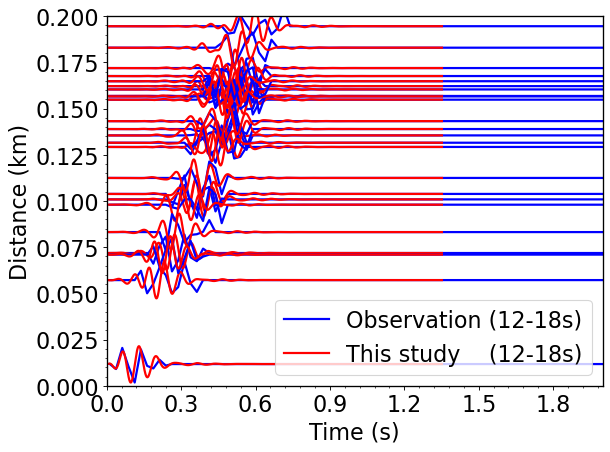

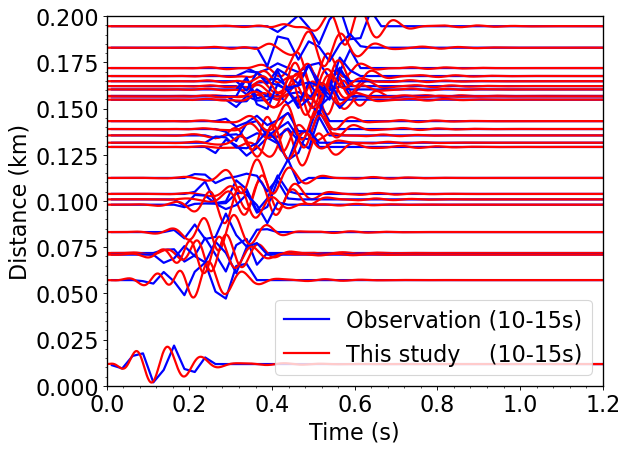

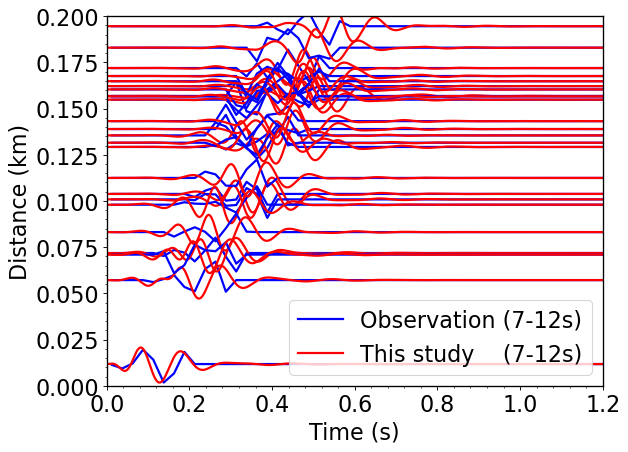

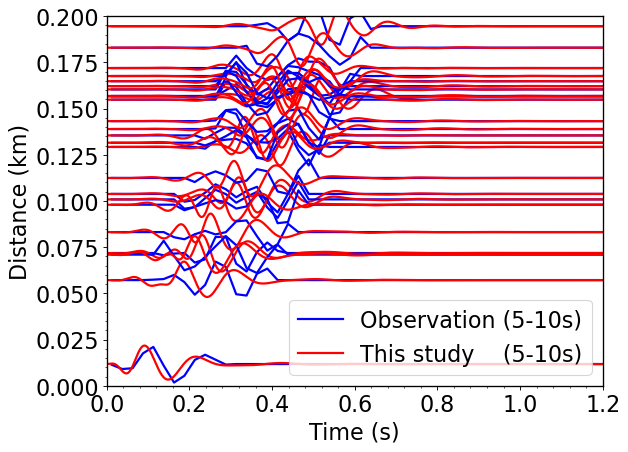

In [412]:
aver = np.array([0.39,0.45,0.5,0.55])
flag_inter = 10
wave0obsc_copy = wave0obsc.copy()
wave1obsc_copy = wave1obsc.copy()
wave2obsc_copy = wave2obsc.copy()
wave3obsc_copy = wave3obsc.copy()
tc = t[:len(t)-stpindx]
#==============================================================================
plt.style.use(dir_src+'/sc.p4.mplstyle')
textx = -0.11
texty =1.07
xlimt = 3 #s
ylimt = 1 #km
scale1 = 0.01
scale2 = 0.01
linew = 2.0
fonts = 25
fig = plt.figure(figsize = (8, 6), dpi = 80)
ax0 = plt.gca()
#fig.text(textx, texty,'(b1)',horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes,fontsize=fonts)
#for j in range(0,40,3):
r_plot_new = []
index_new = []
for i in range(len(r_plot)):
  if r_plot[i] > 0.2:
     continue
  r_plot_new.append(r_plot[i])
  index_new.append(i)
  
for j in range(0,len(r_plot_new),flag_inter):
  index = index_new[j]
  t0 = r_plot[index]/aver[0]-0
  t1 = r_plot[index]/aver[0]+0.23
  indx0 = int(t0/dtobs)
  indx1 = int(t1/dtobs)
  wave0obsc_copy[index,:indx0] = 0
  wave0obsc_copy[index,indx1:] = 0
  pt,= plt.plot(tt, wave0obsc_copy[index,:]/(np.max(abs(wave0obsc_copy[index,:])))*scale2+r_plot[index],'b', antialiased='False',linewidth=linew)
  label = "Observation (12-18s)"
  pt0,= plt.plot(tc, wave0sync[index]/np.max(abs(wave0sync[index]))*scale1+r_plot[index], 'r', antialiased='False', linewidth=linew)
  label0 = "This study    (12-18s)"
#plt.ylim([0, ylimt])
plt.ylim([0., 0.2])
plt.xlim([0, 2])
ax0.xaxis.set_major_locator(ticker.MaxNLocator(7))
ax0.xaxis.set_minor_locator(ticker.MaxNLocator(35))
ax0.yaxis.set_major_locator(ticker.MaxNLocator(9))
ax0.yaxis.set_minor_locator(ticker.MaxNLocator(45))
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')

plt.legend([pt, pt0],[label, label0],  loc=4)
#plt.title('Waveform comparison for 3-7s')
plt.savefig('comparison_12_18s.jpg', dpi=400)

fig = plt.figure(figsize = (8, 6), dpi = 80)
ax0 = plt.gca()
for j in range(0,len(r_plot_new),flag_inter):
  index = index_new[j]
  t0 = r_plot[index]/aver[1]-0.03
  t1 = r_plot[index]/aver[1]+0.23
  indx0 = int(t0/dtobs)
  indx1 = int(t1/dtobs)
  wave1obsc_copy[index,:indx0] = 0
  wave1obsc_copy[index,indx1:] = 0
  pt,= plt.plot(tt, wave1obsc_copy[index,:]/(np.max(abs(wave1obsc_copy[index,:])))*scale2+r_plot[index],'b', antialiased='False',linewidth=linew)
  label = "Observation (10-15s)"
  pt0,= plt.plot(tc, wave1sync[index]/np.max(abs(wave1sync[index]))*scale1+r_plot[index], 'r', antialiased='False', linewidth=linew)
  label0 = "This study    (10-15s)"
#plt.ylim([0, ylimt])
plt.ylim([0., 0.2])
plt.xlim([0, 1.2])
ax0.xaxis.set_major_locator(ticker.MaxNLocator(7))
ax0.xaxis.set_minor_locator(ticker.MaxNLocator(35))
ax0.yaxis.set_major_locator(ticker.MaxNLocator(9))
ax0.yaxis.set_minor_locator(ticker.MaxNLocator(45))
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')
plt.legend([pt, pt0],[label, label0],  loc=4)
#plt.title('Waveform comparison for 3-7s')
plt.savefig('comparison_10_15s.jpg', dpi=400)

fig = plt.figure(figsize = (8, 6), dpi = 80)
ax0 = plt.gca()
for j in range(0,len(r_plot_new),flag_inter):
  index = index_new[j]
  t0 = r_plot[index]/aver[2]
  t1 = r_plot[index]/aver[2]+0.2
  indx0 = int(t0/dtobs)
  indx1 = int(t1/dtobs)
  wave2obsc_copy[index,:indx0] = 0
  wave2obsc_copy[index,indx1:] = 0
  pt,= plt.plot(tt, wave2obsc_copy[index,:]/(np.max(abs(wave2obsc_copy[index,:])))*scale2+r_plot[index],'b', antialiased='False',linewidth=linew)
  label = "Observation (7-12s)"
  pt0,= plt.plot(tc, wave2sync[index]/np.max(abs(wave2sync[index]))*scale1+r_plot[index], 'r', antialiased='False', linewidth=linew)
  label0 = "This study    (7-12s)"
#plt.ylim([0, ylimt])
plt.ylim([0., 0.2])
plt.xlim([0, 1.2])
ax0.xaxis.set_major_locator(ticker.MaxNLocator(7))
ax0.xaxis.set_minor_locator(ticker.MaxNLocator(35))
ax0.yaxis.set_major_locator(ticker.MaxNLocator(9))
ax0.yaxis.set_minor_locator(ticker.MaxNLocator(45))
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')
plt.legend([pt, pt0],[label, label0],  loc=4)
#plt.title('Waveform comparison for 3-7s')
plt.savefig('comparison_7_12s.jpg', dpi=400)

fig = plt.figure(figsize = (8, 6), dpi = 80)
ax0 = plt.gca()
for j in range(0,len(r_plot_new),flag_inter):
  index = index_new[j]
  t0 = r_plot[index]/aver[3]
  t1 = r_plot[index]/aver[3]+0.3
  indx0 = int(t0/dtobs)
  indx1 = int(t1/dtobs)
  wave3obsc_copy[index,:indx0] = 0
  wave3obsc_copy[index,indx1:] = 0
  pt,= plt.plot(tt, wave3obsc_copy[index,:]/(np.max(abs(wave3obsc_copy[index,:])))*scale2+r_plot[index],'b', antialiased='False',linewidth=linew)
  label = "Observation (5-10s)"
  pt0,= plt.plot(tc, wave3sync[index]/np.max(abs(wave3sync[index]))*scale1+r_plot[index], 'r', antialiased='False', linewidth=linew)
  label0 = "This study    (5-10s)"
#plt.ylim([0, ylimt])
plt.ylim([0., 0.2])
plt.xlim([0, 1.2])
ax0.xaxis.set_major_locator(ticker.MaxNLocator(7))
ax0.xaxis.set_minor_locator(ticker.MaxNLocator(35))
ax0.yaxis.set_major_locator(ticker.MaxNLocator(9))
ax0.yaxis.set_minor_locator(ticker.MaxNLocator(45))
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')
plt.legend([pt, pt0],[label, label0],  loc=4)
#plt.title('Waveform comparison for 3-7s')
plt.savefig('comparison_5_10s.jpg', dpi=400)

In [414]:
wave0obsc_copy.shape

(664, 199)